In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import vaex

In [3]:
%%time

df_train = vaex.from_csv("./Datasets/train.csv", convert = True, chunk_size = 3_000_000)

Wall time: 291 ms


Function to reduce the size of our Train DataFrame

In [4]:
def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

## HANDLING MISSING VALUES

In [5]:
%%time 
def get_columns():
    string = 'feature_{}'
    res = []
    for i in range(0,130):
        res.append(string.format(i))
    return res  

val_max = df_train.max(get_columns())
val_max.shape


Wall time: 1.73 s


(130,)

In [6]:
%%time
val_min = df_train.min(get_columns())
val_min.shape

Wall time: 885 ms


(130,)

In [7]:
val_range = val_max - val_min
del val_max
gc.collect()
val_range.shape

(130,)

In [8]:
%%time
features = [f'feature_{i}' for i in range(130)]
filler = pd.Series(val_min - 0.01 * val_range, index = features)
filler

Wall time: 2 ms


feature_0      -1.020000
feature_1      -3.948045
feature_2      -4.604877
feature_3     -25.937615
feature_4     -19.504205
                 ...    
feature_125    -8.923052
feature_126    -8.884486
feature_127    -6.516864
feature_128    -7.607062
feature_129    -6.499571
Length: 130, dtype: float64

In [9]:
%%time
def fill_missing(df, filler):
    df[get_columns()] = df[get_columns()].fillna(filler)
    return df
train = fill_missing(df_train.to_pandas_df() , filler)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB
Wall time: 14.4 s


In [10]:
train_v = vaex.from_pandas(train)
del train
gc.collect()

20

In [11]:
train_v.head()

#,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0,0.00991599,0.0140786,0.00877305,0.00139037,0.00627036,1,-1.87275,-2.19124,-0.474163,-0.323046,0.0146883,-0.00248358,-28.771,-42.7069,-0.989982,-1.05509,-50.295,-64.1242,-2.66767,-2.00147,-1.70359,-2.19689,-32.9311,-44.2323,1.48329,1.30747,-60.4065,-67.4881,1.1752,0.967805,1.60841,1.31937,-26.0871,-46.7651,-0.515073,-0.448988,-49.1213,-68.0964,-2.42981,-2.20642,-3.59312,-2.86836,0.112697,0.0531567,-0.539956,-0.692187,3.49128,-1.68489,1.33712,-0.328607,1.68921,-1.05224,-1.87089,-1.78934,-1.57417,-1.12082,-0.57192,-1.09303,0.703515,5.93628,-11.7336,3.31581,1.29134,2.46882,2.49007,-1.14824,-0.961935,-2.26394,-2.15876,-5.01202,-2.00683,-1.28409,-2.1417,-2.05494,-1.8512,-1.43118,-1.63448,-70.788,-0.373934,-83.5253,0.559241,0.891368,0.2717,-57.5829,-1.52113,-87.7314,3.04534,3.26051,0.683558,-3.11305,-0.109194,-2.19039,0.488806,1.4475,-2.7909,-4.20349,1.15877,-2.87395,3.75452,7.13716,-1.86307,-3.62779,0.434466,-3.56146,-0.292035,0.317003,-2.60582,-5.46032,2.89699,-2.48596,1.48581,4.14725,-2.23883,-6.51205,-0.892724,-3.08207,-0.156332,0.622816,-3.92152,-5.83633,2.56159,-5.04657,3.45776,6.64958,-1.47269,-5.5897,-8.65446,1.16839,8.31358,1.78243,14.0182,2.65306,12.6003,2.30149,11.4458,0
1,0,16.6735,-0.00282823,-0.00322632,-0.00731949,-0.0111141,-0.00979168,-1,-1.34954,-1.70471,0.0680576,0.0284323,0.193794,0.138212,-28.771,-42.7069,-0.151877,-0.384952,-50.295,-64.1242,1.22584,0.789076,1.11058,1.10228,-32.9311,-44.2323,-0.5906,-0.625682,-60.4065,-67.4881,-0.543425,-0.547486,-0.7066,-0.667806,-26.0871,-46.7651,0.910558,0.914465,-49.1213,-68.0964,2.13745,2.08046,2.81929,2.48396,-0.0867548,-0.0826874,0.368431,0.469196,5.712,-2.21513,0.796703,-1.14008,0.716617,-0.0594313,-0.19892,-0.326697,-0.38177,1.43561,3.40139,2.48675,-2.0146,-0.390588,-11.7336,-0.027262,-1.88693,-1.70645,-0.888236,-1.13829,-0.954461,-1.35063,-1.45955,-4.56481,-2.65197,-1.62001,-2.24062,-2.14727,-0.255224,3.20295,-0.535872,-70.788,-0.050948,-83.5253,0.141089,0.058363,0.13119,-57.5829,-0.121239,-87.7314,0.677553,0.0458419,-0.124616,-3.11305,-0.00700393,-2.19039,-0.410491,-0.0243228,-3.01265,-4.20349,1.15767,-2.87395,1.29768,1.28196,-2.42759,-3.62779,0.0249128,-3.56146,-0.413607,-0.0736718,-2.43455,-5.46032,0.949879,-2.48596,0.724655,1.62214,-2.20902,-6.51205,-1.33249,-3.08207,-0.586619,-1.04049,-3.9461,-5.83633,0.98344,-5.04657,1.35791,1.61235,-1.66454,-5.5897,-8.65446,-1.17885,1.77747,-0.915458,2.83161,-1.41701,2.29746,-1.30461,1.89868,1
2,0,0,0.0251339,0.0276074,0.0334057,0.0343797,0.0239701,-

In [12]:
train_v.describe()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
dtype,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
count,2390491,2390491,2390491,2390491,2390491,2390491,2390491,2390491,2390491,2390491,...,2390491,2390491,2390491,2390491,2390491,2390491,2390491,2390491,2390491,2390491
NA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mean,247.86684241856588,3.0315352105293094,0.00014349689624170505,0.0001980748897542341,0.0002824182759969406,0.0004350200749101303,0.0004083112880542499,0.009838564545944745,0.38557755173129027,0.35768747744650975,...,0.008024344093699405,0.34292296893661905,0.2792839701840133,0.30078665825769196,0.18319428842618884,0.30501866421544166,0.20738555739289163,0.33617250532852194,0.24019774431620408,1195245.0
std,152.274598,7.672792,0.00893,0.012302,0.019069,0.032912,0.026936,0.999952,2.559372,2.477335,...,2.616854,2.088761,1.978929,1.786211,2.357589,2.591099,1.83881,2.317178,1.77503,690075.311174
min,0,0.0,-0.367504,-0.532833,-0.56812,-0.598745,-0.549384,-1,-3.172026,-3.093182,...,-8.654461,-6.40286,-7.366482,-4.772979,-8.923052,-8.884486,-6.516864,-7.607062,-6.499571,0
max,499,167.293715,0.245348,0.294934,0.32656,0.511379,0.448462,1,74.429889,148.076314,...,110.777051,48.12516,127.690843,65.145172,70.528067,58.728493,69.322208,51.190378,116.45677,2390490


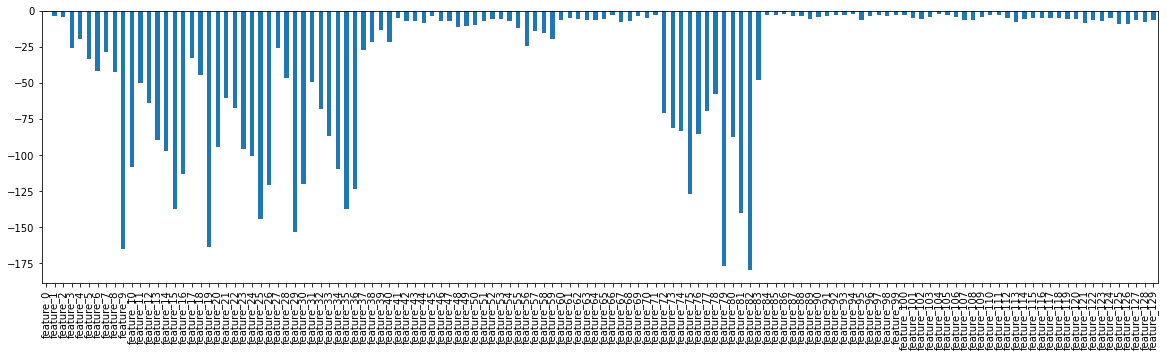

In [13]:
filler.plot(kind = 'bar', rot = 90, figsize = (20,5))


Now we can see from the table above that we dont have any missing value, Now based on the notebook Data_visualization we are trying to do some:

## FEATURE ENGINEERING


Let's try to generate some more features and see how the correlate with our target

In [14]:
train_v.head(10)

#,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0,0.00991599,0.0140786,0.00877305,0.00139037,0.00627036,1,-1.87275,-2.19124,-0.474163,-0.323046,0.0146883,-0.00248358,-28.771,-42.7069,-0.989982,-1.05509,-50.295,-64.1242,-2.66767,-2.00147,-1.70359,-2.19689,-32.9311,-44.2323,1.48329,1.30747,-60.4065,-67.4881,1.1752,0.967805,1.60841,1.31937,-26.0871,-46.7651,-0.515073,-0.448988,-49.1213,-68.0964,-2.42981,-2.20642,-3.59312,-2.86836,0.112697,0.0531567,-0.539956,-0.692187,3.49128,-1.68489,1.33712,-0.328607,1.68921,-1.05224,-1.87089,-1.78934,-1.57417,-1.12082,-0.57192,-1.09303,0.703515,5.93628,-11.7336,3.31581,1.29134,2.46882,2.49007,-1.14824,-0.961935,-2.26394,-2.15876,-5.01202,-2.00683,-1.28409,-2.1417,-2.05494,-1.8512,-1.43118,-1.63448,-70.788,-0.373934,-83.5253,0.559241,0.891368,0.2717,-57.5829,-1.52113,-87.7314,3.04534,3.26051,0.683558,-3.11305,-0.109194,-2.19039,0.488806,1.4475,-2.7909,-4.20349,1.15877,-2.87395,3.75452,7.13716,-1.86307,-3.62779,0.434466,-3.56146,-0.292035,0.317003,-2.60582,-5.46032,2.89699,-2.48596,1.48581,4.14725,-2.23883,-6.51205,-0.892724,-3.08207,-0.156332,0.622816,-3.92152,-5.83633,2.56159,-5.04657,3.45776,6.64958,-1.47269,-5.5897,-8.65446,1.16839,8.31358,1.78243,14.0182,2.65306,12.6003,2.30149,11.4458,0
1,0,16.6735,-0.00282823,-0.00322632,-0.00731949,-0.0111141,-0.00979168,-1,-1.34954,-1.70471,0.0680576,0.0284323,0.193794,0.138212,-28.771,-42.7069,-0.151877,-0.384952,-50.295,-64.1242,1.22584,0.789076,1.11058,1.10228,-32.9311,-44.2323,-0.5906,-0.625682,-60.4065,-67.4881,-0.543425,-0.547486,-0.7066,-0.667806,-26.0871,-46.7651,0.910558,0.914465,-49.1213,-68.0964,2.13745,2.08046,2.81929,2.48396,-0.0867548,-0.0826874,0.368431,0.469196,5.712,-2.21513,0.796703,-1.14008,0.716617,-0.0594313,-0.19892,-0.326697,-0.38177,1.43561,3.40139,2.48675,-2.0146,-0.390588,-11.7336,-0.027262,-1.88693,-1.70645,-0.888236,-1.13829,-0.954461,-1.35063,-1.45955,-4.56481,-2.65197,-1.62001,-2.24062,-2.14727,-0.255224,3.20295,-0.535872,-70.788,-0.050948,-83.5253,0.141089,0.058363,0.13119,-57.5829,-0.121239,-87.7314,0.677553,0.0458419,-0.124616,-3.11305,-0.00700393,-2.19039,-0.410491,-0.0243228,-3.01265,-4.20349,1.15767,-2.87395,1.29768,1.28196,-2.42759,-3.62779,0.0249128,-3.56146,-0.413607,-0.0736718,-2.43455,-5.46032,0.949879,-2.48596,0.724655,1.62214,-2.20902,-6.51205,-1.33249,-3.08207,-0.586619,-1.04049,-3.9461,-5.83633,0.98344,-5.04657,1.35791,1.61235,-1.66454,-5.5897,-8.65446,-1.17885,1.77747,-0.915458,2.83161,-1.41701,2.29746,-1.30461,1.89868,1
2,0,0,0.0251339,0.0276074,0.0334057,0.0343797,0.0239701,-

In [15]:
%%time 
def get_columns_s():
    string = 'shift_feature_{}'
    res = []
    for i in range(0,130):
        res.append(string.format(i))
    return res
for fet, sh in zip(get_columns(), get_columns_s()):
    val_min =  df_train.min(fet)
    train_v[sh] = train_v[fet] + abs(val_min + 1).astype(np.float16)
    print(fet)
train_v.head(10)

feature_0
feature_1
feature_2
feature_3
feature_4
feature_5
feature_6
feature_7
feature_8
feature_9
feature_10
feature_11
feature_12
feature_13
feature_14
feature_15
feature_16
feature_17
feature_18
feature_19
feature_20
feature_21
feature_22
feature_23
feature_24
feature_25
feature_26
feature_27
feature_28
feature_29
feature_30
feature_31
feature_32
feature_33
feature_34
feature_35
feature_36
feature_37
feature_38
feature_39
feature_40
feature_41
feature_42
feature_43
feature_44
feature_45
feature_46
feature_47
feature_48
feature_49
feature_50
feature_51
feature_52
feature_53
feature_54
feature_55
feature_56
feature_57
feature_58
feature_59
feature_60
feature_61
feature_62
feature_63
feature_64
feature_65
feature_66
feature_67
feature_68
feature_69
feature_70
feature_71
feature_72
feature_73
feature_74
feature_75
feature_76
feature_77
feature_78
feature_79
feature_80
feature_81
feature_82
feature_83
feature_84
feature_85
feature_86
feature_87
feature_88
feature_89
feature_90
feature_9

#,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,shift_feature_0,shift_feature_1,shift_feature_2,shift_feature_3,shift_feature_4,shift_feature_5,shift_feature_6,shift_feature_7,shift_feature_8,shift_feature_9,shift_feature_10,shift_feature_11,shift_feature_12,shift_feature_13,shift_feature_14,shift_feature_15,shift_feature_16,shift_feature_17,shift_feature_18,shift_feature_19,shift_feature_20,shift_feature_21,shift_feature_22,shift_feature_23,shift_feature_24,shift_feature_25,shift_feature_26,shift_feature_27,shift_feature_28,shift_feature_29,shift_feature_30,shift_feature_31,shift_feature_32,shift_feature_33,shift_feature_34,shift_feature_35,shift_feature_36,shift_feature_37,shift_feature_38,shift_feature_39,shift_feature_40,shift_feature_41,shift_feature_42,shift_feature_43,shift_feature_44,shift_feature_45,shift_feature_46,shift_feature_47,shift_feature_48,shift_feature_49,shift_feature_50,shift_feature_51,shift_feature_52,shift_feature_53,shift_feature_54,shift_feature_55,shift_feature_56,shift_feature_57,shift_feature_58,shift_feature_59,shift_feature_60,shift_feature_61,shift_feature_62,shift_feature_63,shift_feature_64,shift_feature_65,shift_feature_66,shift_feature_67,shift_feature_68,shift_feature_69,shift_feature_70,shift_feature_71,shift_feature_72,shift_feature_73,shift_feature_74,shift_feature_75,shift_feature_76,shift_feature_77,shift_feature_78,shift_feature_79,shift_feature_80,shift_feature_81,shift_feature_82,shift_feature_83,shift_feature_84,shift_feature_85,shift_feature_86,shift_feature_87,shift_feature_88,shift_feature_89,shift_feature_90,shift_feature_91,shift_feature_92,shift_feature_93,shift_feature_94,shift_feature_95,shift_feature_96,shift_feature_97,shift_feature_98,shift_feature_99,shift_feature_100,shift_feature_101,shift_feature_102,shift_feature_103,shift_feature_104,shift_feature_105,shift_feature_106,shift_feature_107,shift_feature_108,shift_feature_109,shift_feature_110,shift_feature_111,shift_feature_112,shift_feature_113,shift_feature_114,shift_feature_115,shift_feature_116,shift_feature_117,shift_feature_118,shift_feature_119,shift_feature_120,shift_feature_121,shift_feature_122,shift_feature_123,shift_feature_124,shift_feature_125,shift_feature_126,shift_feature_127,shift_feature_128,shift_feature_129
0,0,0,0.00991599,0.0140786,0.00877305,0.00139037,0.00627036,1,-1.87275,-2.19124,-0.474163,-0.323046,0.0146883,-0.00248358,-28.771,-42.7069,-0.989982,-1.05509,-50.295,-64.1242,-2.66767,-2.00147,-1.70359,-2.19689,-32.9311,-44.2323,1.48329,1.30747,-60.4065,-67.4881,1.17

In [16]:
%%time
def get_columns_l():
    string = 'log_feature_{}'
    res = []
    for i in range(0,130):
        res.append(string.format(i))
    return res
def get_columns_t():
    string = 'sqrt_feature_{}'
    res = []
    for i in range(0,130):
        res.append(string.format(i))
    return res
for sh, log, sqrt  in zip(get_columns_s(),get_columns_l(),get_columns_t()):
    train_v[log] = np.log(train_v[sh])
    train_v[sqrt] = np.sqrt(train_v[sh])
    print(sh, end='')
train_v.drop(get_columns_s(), inplace = True)
train_v.head(10)

shift_feature_0shift_feature_1shift_feature_2shift_feature_3shift_feature_4shift_feature_5shift_feature_6shift_feature_7shift_feature_8shift_feature_9shift_feature_10shift_feature_11shift_feature_12shift_feature_13shift_feature_14shift_feature_15shift_feature_16shift_feature_17shift_feature_18shift_feature_19shift_feature_20shift_feature_21shift_feature_22shift_feature_23shift_feature_24shift_feature_25shift_feature_26shift_feature_27shift_feature_28shift_feature_29shift_feature_30shift_feature_31shift_feature_32shift_feature_33shift_feature_34shift_feature_35shift_feature_36shift_feature_37shift_feature_38shift_feature_39shift_feature_40shift_feature_41shift_feature_42shift_feature_43shift_feature_44shift_feature_45shift_feature_46shift_feature_47shift_feature_48shift_feature_49shift_feature_50shift_feature_51shift_feature_52shift_feature_53shift_feature_54shift_feature_55shift_feature_56shift_feature_57shift_feature_58shift_feature_59shift_feature_60shift_feature_61shift_feature_62sh

759        -60.4065      -67.4881    -1.97445      -2.07969      -2.47989      -2.30535        -26.0871      -46.7651      1.16157       0.844683      -49.1213      -68.0964      2.8653        2.19601       3.40864       2.30884     -0.278407     -0.238325      0.505571      0.490364      0.347092     -0.291826       2.01416      0.958318       0.890369     0.992053       1.69797       1.08247      0.507744       1.83398       1.13808       3.19697       2.29227      4.60779        -11.7336      0.803517     0.334937       1.25207       1.67737       -1.12123     -0.940438      -2.33026      -2.30857      -4.23913      -3.06927      -1.84712      -2.11132      -2.02574     -0.915058     -1.35363      -1.2536         -70.788     0.306105       -83.5253      0.376678      0.282811    0.472433        -57.5829     0.312573       -87.7314      0.851852     0.295275      0.722047       -3.11305    0.0745581       -2.19039    -0.624706     -0.321629       -2.39387      -4.20349      0.199255      -2.87395     -0.121806     -0.168498      -2.40802      -3.62779    -1.33886        -3.56146     -1.25777      -1.19401         -2.64702       -5.46032      -0.94019        -2.48596      -1.51022       -1.78169        -3.31328       -6.51205     -1.94919         -3.08207     -1.08576        -2.4442         -3.51112       -5.83633      -1.51948        -5.04657      -1.4683       -1.90921         -1.97824        -5.5897       -8.65446       2.102          4.8462         1.47988         5.26133       2.30507         4.57176       2.20154         4.42974        7              nan               nan         0.962382          1.618            0.48707           1.27575           3.2157            4.99206          2.91067           4.28592          3.46349           5.6505           3.68823           6.32251              nan               nan              nan               nan          5.0808            12.6847           4.65495            10.252                nan                nan               nan                nan           4.49088            9.44458           4.56168            9.78492           4.90527            11.6189           4.70479            10.5107               nan                nan               nan                nan           5.05852            12.5442           4.49705            9.47377               nan                nan               nan                nan           4.5077             9.52434           4.56287            9.7907            4.9274             11.7482           4.74662            10.7329               nan                nan               nan                nan           5.01918            12.2999           4.76724            10.8441               nan                nan               nan                nan           4.4658             9.32686           4.68913            10.4287           4.92568            11.7381           4.81012            11.0791           3.2277             5.02211           2.99475            4.46995           2.54842            3.57587           3.04406            4.58152           1.45821            2.07323           1.75886            2.40953           2.09765            2.85429           2.00985            2.73171          1.11659             1.74769          1.26603             1.88328           1.97488            2.68436          1.71261             2.35444          1.20941             1.83071          1.76202             2.41334          1.68853             2.32627           2.0772             2.82527          1.89251             2.57605          2.15674             2.93989               nan                nan         0.564237            1.32594           1.58712             2.21125           2.03834            2.77089           1.81709            2.48071           1.37051            1.98428          1.08451             1.71988          0.7601              1.46236          1.10252             1.73544         0.18096             1.0947           0.322045             1.17471        

In [32]:
train_v.head(10)

-67.4881    -1.97445      -2.07969      -2.47989      -2.30535        -26.0871      -46.7651      1.16157       0.844683      -49.1213      -68.0964      2.8653        2.19601       3.40864       2.30884     -0.278407     -0.238325      0.505571      0.490364      0.347092     -0.291826       2.01416      0.958318       0.890369     0.992053       1.69797       1.08247      0.507744       1.83398       1.13808       3.19697       2.29227      4.60779        -11.7336      0.803517     0.334937       1.25207       1.67737       -1.12123     -0.940438      -2.33026      -2.30857      -4.23913      -3.06927      -1.84712      -2.11132      -2.02574     -0.915058     -1.35363      -1.2536         -70.788     0.306105       -83.5253      0.376678      0.282811    0.472433        -57.5829     0.312573       -87.7314      0.851852     0.295275      0.722047       -3.11305    0.0745581       -2.19039    -0.624706     -0.321629       -2.39387      -4.20349      0.199255      -2.87395     -0.121806     -0.168498      -2.40802      -3.62779    -1.33886        -3.56146     -1.25777      -1.19401         -2.64702       -5.46032      -0.94019        -2.48596      -1.51022       -1.78169        -3.31328       -6.51205     -1.94919         -3.08207     -1.08576        -2.4442         -3.51112       -5.83633      -1.51948        -5.04657      -1.4683       -1.90921         -1.97824        -5.5897       -8.65446       2.102          4.8462         1.47988         5.26133       2.30507         4.57176       2.20154         4.42974        7              nan               nan         0.962382          1.618            0.48707           1.27575           3.2157            4.99206          2.91067           4.28592          3.46349           5.6505           3.68823           6.32251              nan               nan              nan               nan          5.0808            12.6847           4.65495            10.252                nan                nan               nan                nan           4.49088            9.44458           4.56168            9.78492           4.90527            11.6189           4.70479            10.5107               nan                nan               nan                nan           5.05852            12.5442           4.49705            9.47377               nan                nan               nan                nan           4.5077             9.52434           4.56287            9.7907            4.9274             11.7482           4.74662            10.7329               nan                nan               nan                nan           5.01918            12.2999           4.76724            10.8441               nan                nan               nan                nan           4.4658             9.32686           4.68913            10.4287           4.92568            11.7381           4.81012            11.0791           3.2277             5.02211           2.99475            4.46995           2.54842            3.57587           3.04406            4.58152           1.45821            2.07323           1.75886            2.40953           2.09765            2.85429           2.00985            2.73171          1.11659             1.74769          1.26603             1.88328           1.97488            2.68436          1.71261             2.35444          1.20941             1.83071          1.76202             2.41334          1.68853             2.32627           2.0772             2.82527          1.89251             2.57605          2.15674             2.93989               nan                nan         0.564237            1.32594           1.58712             2.21125           2.03834            2.77089           1.81709            2.48071           1.37051            1.98428          1.08451             1.71988          0.7601              1.46236          1.10252             1.73544         0.18096             1.0947           0.322045             1.17471        -1.19314             0.55

In [31]:
train_v.describe()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,sqrt_feature_125,log_feature_126,sqrt_feature_126,log_feature_127,sqrt_feature_127,log_feature_128,sqrt_feature_128,log_feature_129,sqrt_feature_129,action
dtype,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
count,2390491,2390491,2390491,2390491,2390491,2390491,2390491,2390491,2390491,2390491,...,2374389,2381624,2381624,2381542,2381542,2388544,2388544,2388383,2388383,2390491
NA,0,0,0,0,0,0,0,0,0,0,...,16102,8867,8867,8949,8949,1947,1947,2108,2108,0
mean,247.86684241856588,3.0315352105293094,0.00014349689624170505,0.00019807488975423412,0.00028241827599694057,0.0004350200749101303,0.0004083112880542499,0.009838564545944745,0.38557755173129027,0.35768747744650975,...,2.6867287370494886,1.9671977355563934,2.7114037058285336,1.5474059632128823,2.2020138063416974,1.7881210416186208,2.4841131437992736,1.43848229432443,2.0906896592570776,0.5075898633376993
std,152.274598,7.672792,0.00893,0.012302,0.019069,0.032912,0.026936,0.999952,2.559372,2.477335,...,0.403911,0.335344,0.449842,0.358809,0.38646,0.358386,0.441874,0.388293,0.395291,0.499942
min,0,0.0,-0.367504,-0.532833,-0.56812,-0.598745,-0.549384,-1,-3.172026,-3.093182,...,0.092131,-6.386859,0.041031,-7.866203,0.019583,-4.986293,0.082649,-6.044074,0.048702,False
max,499,167.293715,0.245348,0.294934,0.32656,0.511379,0.448462,1,74.429889,148.076314,...,8.812763,4.188796,8.12055,4.305251,8.607429,4.046795,7.563981,4.793623,10.988085,True


In [29]:
y = train_v[[c for c in train_v.get_column_names() if 'resp' in c]].to_pandas_df()
y = (y>0)*1
train_v['action'] = (y.mean(axis=1)>0.5).to_numpy()

In [35]:
train_v.action.str.replace(pat='True', repl='1')

Expression = str_replace(action, pat='True', repl='1')
Length: 2,390,491 dtype: str (expression)
-----------------------------------------
      0
      1  None
      2  None
      3  None
      4  None
     ...     
2390486
2390487  None
2390488  None
2390489  None
2390490  None

In [ ]:
train_v.action